# Creating an instance of VGG16

In [6]:
from keras.applications.vgg16 import preprocess_input,VGG16,decode_predictions
from keras.preprocessing import image
import keras.backend as k
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Model

In [7]:
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 7s 0us/step


In [8]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

visualizing the filters of the first layer. 

In [9]:
filters, biases = model.layers[1].get_weights()

In [10]:
f_max, f_min = filters.max(), filters.min()

In [11]:
filters = (filters-f_min)/(f_max-f_min)

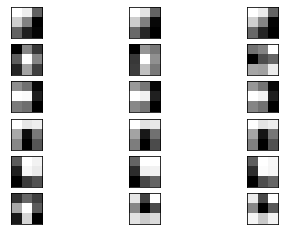

In [12]:
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [13]:
from skimage import io

Low-Level Feature map

Note: In-order to obtain feature maps at different stages of the network, we must create another instance of model which has the same architecture as VGG16 up until a specified layer. Keras Model API helps create a model upto any given level of VGG16. 

In [84]:
car = io.imread("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/tesla-model-s-1563301327.jpg")

In [85]:
car = cv2.resize(car,dsize=(224,224), interpolation=cv2.INTER_CUBIC)
car_img = image.img_to_array(car)
car_img = np.expand_dims(car_img,axis=0)
car_img = preprocess_input(car_img)

In [86]:
# Instance of VGG16 model till layer 1. 
feature_map_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [87]:
feature_map_model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [18]:
car_features = feature_map_model.predict(car_img)

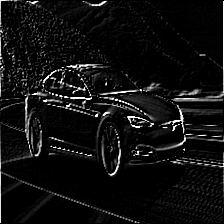

In [80]:
feature_map_1 = car_features[0,:,:,0]
cv2_imshow(feature_map_1)

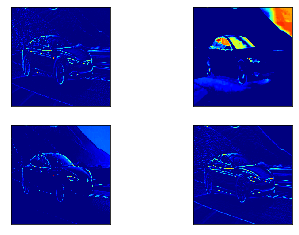

In [54]:
ix=1
for _ in range(2):
  for _ in range(2):
    # cv2_imshow(car_features[0,:,:,ix-1])
    # ix+=1
    ax = plt.subplot(2,2,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(car_features[0,:,:,ix-1], cmap='jet',interpolation='nearest',aspect='equal')
    ix += 1

plt.show()
  


Mid-Level Feature maps.

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

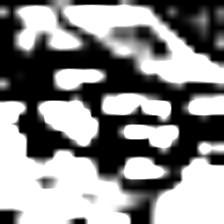

In [105]:
feature_map_net = Model(inputs=model.inputs,outputs=model.layers[11].output)
feature_map_net.summary()
car_features_2 = feature_map_net.predict(car_img)
car_features_2_resized = cv2.resize(car_features_2[0,:,:,110],(224,224))
cv2_imshow(car_features_2_resized)


# GradCAM

In [67]:
car_features_2_resized.shape

(224, 224)

In [22]:
dog = io.imread("https://cdn.cnn.com/cnnnext/dam/assets/200213091700-cafe-diamon-princess-infected-onboard.jpg")
dog = cv2.resize(dog, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)

In [24]:
x = np.expand_dims(x,axis=0)

In [26]:
x = preprocess_input(x)

In [27]:
prediction = model.predict(x)

In [28]:
class_idx = np.argmax(prediction[0])

In [29]:
class_idx

628

In [30]:
class_output = model.output[:,class_idx]

In [31]:
# Select the layer at which gradCAM has to be computed. 
last_conv_layer = model.get_layer('block5_conv3')

In [32]:
# Calculate gradient of output class score wrt the feature maps of selected convolutional layer.
grads = k.gradients(class_output,last_conv_layer.output)[0]
print(grads.shape)


(None, 14, 14, 512)


In [33]:
# Compute mean of the gradient feature map.
pooled_grads = k.mean(grads,axis=(0,1,2))

In [34]:
# Obtain the output feature map from the selected layer. 
iterate = k.function([model.input], [pooled_grads,last_conv_layer.output[0]])
pooled_grads_value, feature_map_conv = iterate([x])

In [35]:
feature_map_conv.shape

(14, 14, 512)

In [36]:
# Multiplying the feature maps with pooled gradients to obtain GradCAM
for i in range(512):
  feature_map_conv[:,:,i] *= pooled_grads_value[i]

In [37]:
heatmap = np.mean(feature_map_conv, axis=-1)
print(feature_map_conv.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap,0)

(14, 14, 512)
(14, 14)


In [38]:
heatmap /= np.max(heatmap)

In [41]:
type(heatmap)

numpy.ndarray

In [39]:
heatmap = cv2.resize(heatmap,(dog.shape[1],dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
super_imposed_img = cv2.addWeighted(dog,0.5, heatmap, 0.5, 0)

In [47]:
type(super_imposed_img)

numpy.ndarray

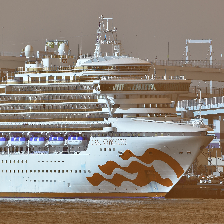

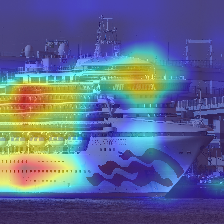

In [40]:
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(super_imposed_img)